## Riddle
Riddler Headquarters is a buzzing hive of activity. Mathematicians, statisticians and programmers roam the halls at all hours, proving theorems and calculating probabilities. They’re fueled, of course, by caffeine. But the headquarters has just one coffee pot, along with one unbreakable rule: You finish the joe, you make some mo’.

Specifically, the coffee pot holds one gallon of coffee, and workers fill their mugs from it in sequence. Whoever takes the last drop has to make the next pot, no ifs, ands or buts. Every worker in the office is trying to take as much coffee as he or she can while minimizing the probability of having to refill the pot. Also, this pot is both incredibly heavy and completely opaque, so it’s tough to tell how much remains. That means a worker can’t keep pouring until she sees or feels just a drop left. Anyone stuck refilling the pot becomes so frustrated that they throw their cup to the ground in frustration, so they get no coffee that round.

Congratulations! You’ve just been hired to work at Riddler Headquarters. Submit a number between 0 and 1. (It could be 0.9999, or 0.0001, or 0.5, or 0.12345, and so on.) This is the number of gallons of coffee you will attempt to take from the pot each time you go for a cup. If that amount remains, lucky you, you get to drink it. If less remains, you’re out of luck that round; you must refill the pot, and you get no coffee.

Once I’ve received your submissions, I’ll randomize the order in which you and your colleagues head for the pot. Then I’ll run a lot of simulations — thousands of hypothetical trips to the coffee pot in the Riddler offices. Whoever drinks the most coffee is the ☕ Caffeine King or Queen ☕ of Riddler Headquarters!

[https://fivethirtyeight.com/features/can-you-drink-more-coffee-than-your-coworkers/](https://fivethirtyeight.com/features/can-you-drink-more-coffee-than-your-coworkers/)

## Methodology

This is all about predicting what I think potential distributions will be like.  I chose to simulate some possible distributions that I thought the answers might resemble, then pick an answer from looking at the results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import pickle
import itertools
from collections import Counter
from tqdm import tqdm_notebook

FULL_POT_SIZE = 1

In [2]:
def run_coffee_simulation(amounts):
    coffee_remaining = FULL_POT_SIZE
    np.random.shuffle(amounts)
    result = []

    for idx, amount in np.ndenumerate(amounts):
        coffee_remaining -= amount
        if coffee_remaining < 0:
            coffee_remaining = FULL_POT_SIZE
        else:
            result.append(amount)

    return result

In [3]:
def limit(input, lower_limit=0.0, upper_limit=1.0):
    if input > upper_limit:
        return upper_limit - np.random.uniform(0.001, 0.01)
    elif input <= lower_limit:
        return lower_limit - np.random.uniform(0.001, 0.01)
    else:
        return input

In [4]:
def plot_results(cumul, count, amounts, name):
    fig, axes = plt.subplots(4, figsize=(8, 16))

    axes[0].set_title(name)

    for a in axes:
        a.grid(which='major', linestyle='-', linewidth='0.5')
        a.autoscale(enable=True, axis='y')

    
    axes[0].hist(amounts, bins=20, range=(0, 1), normed=True, edgecolor='black')
    axes[0].set_ylabel('Likelihood of Amount')

    axes[1].set_xlim([0, 1])
    axes[1].scatter(*zip(*cumul.items()), alpha=0.05)
    axes[1].set_ylabel('Average Amount Received')

    axes[2].set_xlim([0, 1])
    axes[2].scatter(*zip(*count.items()), alpha=0.05)
    axes[2].set_ylabel('Percent of Trips Able to Fill')

    window_lim = 0.65
    data = [(a, r) for a, r in cumul.items() if a >= window_lim]
    axes[3].scatter(*zip(*data), alpha=0.2)
    axes[3].set_ylabel('Average Amount Received')
    axes[3].set_xlabel('Attempted Fill Amount')
    axes[3].set_xlim([window_lim, 1])

    fig.savefig(f'plots/{name}.png')
    
    plt.show()

In [5]:
def perform_analysis(amounts, num_simulations, name):
    name = name.replace(" ", "_")
    lim_vec = np.vectorize(limit)
    amounts = lim_vec(amounts)

    sim_results = Counter()

    with tqdm_notebook(total=num_simulations, desc=name) as pbar:
        with Pool(processes=4) as p:
            for result in p.imap_unordered(run_coffee_simulation,
                                           itertools.repeat(amounts, num_simulations)):
                sim_results.update(result)
                pbar.update(1)

    cumul = {amt: (amt * cnt) / num_simulations for amt, cnt in sim_results.items()}
    count = {amt: cnt / num_simulations for amt, cnt in sim_results.items()}

    pickle.dump((cumul, count, amounts, name), open(f'pickles/{name}.pkl', 'wb'))
    
    return cumul, count, amounts, name

In [6]:
NUM_EMPLOYEES = 2000
NUM_SIMULATIONS = 100000

In [7]:
uniform_results = perform_analysis(np.random.uniform(size=NUM_EMPLOYEES),
                                   NUM_SIMULATIONS,
                                   "uniform")

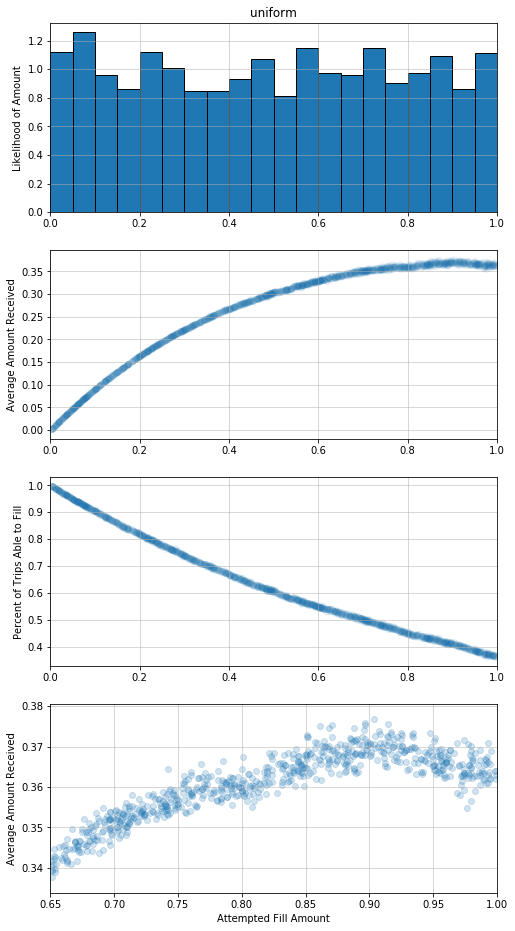

In [8]:
plot_results(*uniform_results)

In [9]:
left = np.random.normal(0.2, 0.1, size=(NUM_EMPLOYEES // 2))
right = np.random.normal(0.8, 0.1, size=(NUM_EMPLOYEES - (NUM_EMPLOYEES // 2)))
bimodal_results = perform_analysis(np.concatenate((left, right)),
                                   NUM_SIMULATIONS,
                                   "bimodal normal")

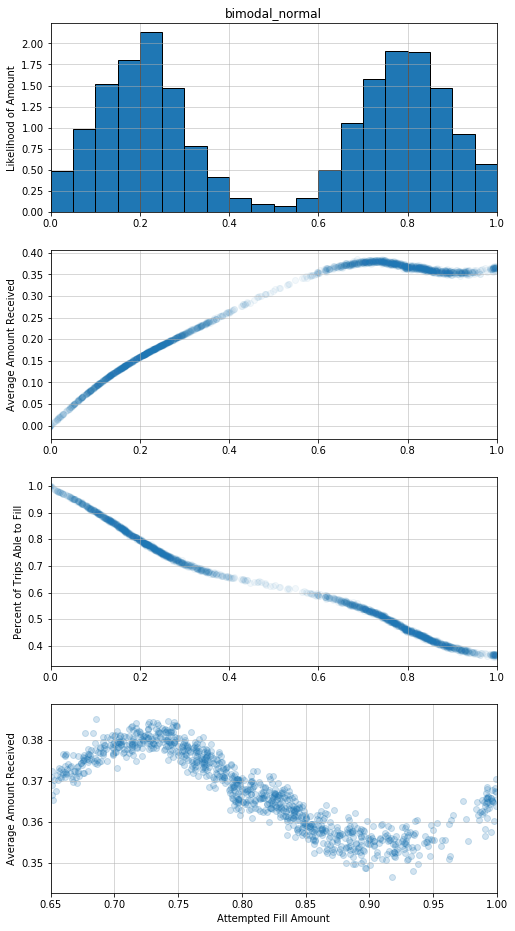

In [10]:
plot_results(*bimodal_results)

In [11]:
normal_high_results = perform_analysis(np.random.normal(0.7, 0.15, size=NUM_EMPLOYEES),
                                       NUM_SIMULATIONS,
                                       "normal high")

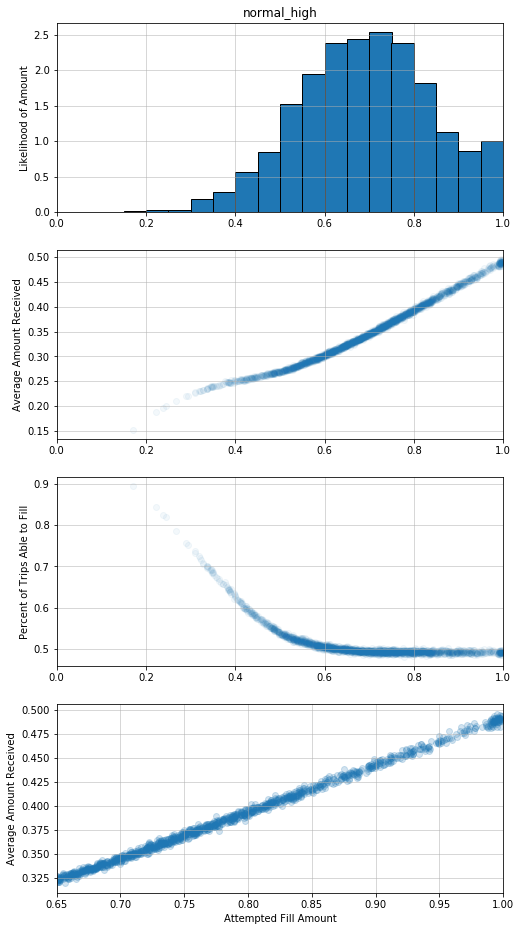

In [12]:
plot_results(*normal_high_results)

In [13]:
beta_high_results = perform_analysis(np.random.beta(5, 2, size=NUM_EMPLOYEES),
                                     NUM_SIMULATIONS,
                                     "beta high")

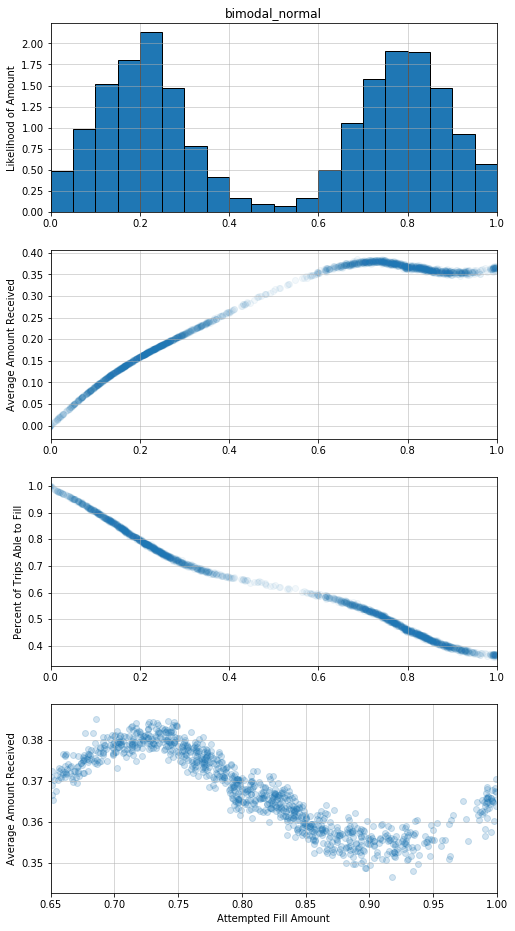

In [14]:
plot_results(*bimodal_results)

In [15]:
uniform_high_results = perform_analysis(np.random.uniform(0.65, 1, size=NUM_EMPLOYEES),
                                        NUM_SIMULATIONS,
                                        "uniform high")

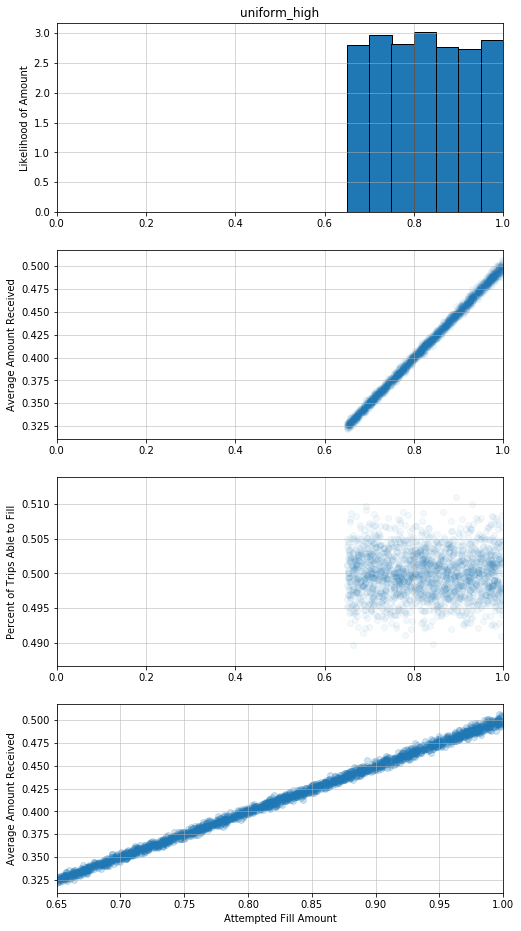

In [16]:
plot_results(*uniform_high_results)

In [17]:
beta_low_results = perform_analysis(np.random.beta(2, 5, size=NUM_EMPLOYEES),
                                    NUM_SIMULATIONS,
                                    "beta low")

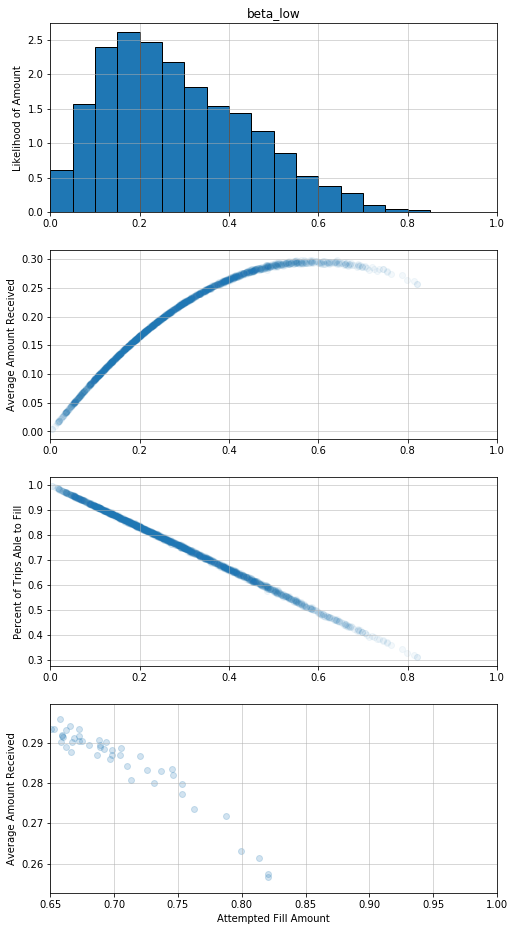

In [18]:
plot_results(*beta_low_results)

In [19]:
normal_center_results = perform_analysis(np.random.normal(0.5, 0.2, size=NUM_EMPLOYEES),
                                         NUM_SIMULATIONS,
                                         "normal centered")

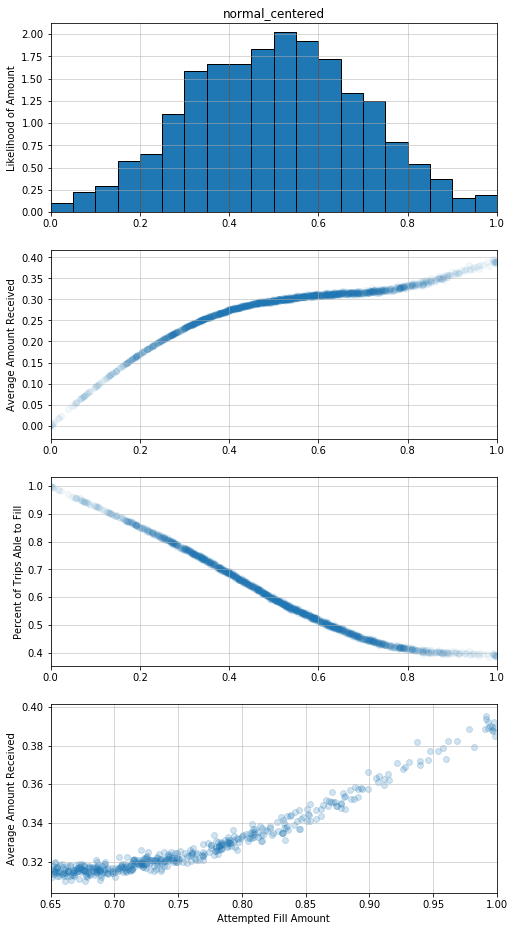

In [20]:
plot_results(*normal_center_results)

Looking at the answers, it seems that once the majority of people are above 0.5, the pot will be refilled pretty much every other time, so there's not much sense in guessing low.  On the other hand, guessing low will yield such small returns in all cases that it isn't viable.

I chose to just guess 1.  In hindsight, I should have guessed just slightly under 1 to account for very small trollish answers, but hindsight is 20/20 :)